# BEN_tutorial_Ⅱ_cross_modality
Note: to replicate experiments conveniently, we did not package key functions as '.exe' files here. Preprocessing is also simplified.

---
<font size=5>Table of Contents</font>

* [1.0 Set up](#1.0)
  * [1.1 Verify Runtime Settings](#1.1)
  * [1.2 Set up environment and install all necessary packages](#1.2)
  * [1.3 Download code from github](#1.3)
  * [1.4 Download MRI data](#1.4)
* [2.0 Cross modality (T2WI -> EPI/fMRI)](#2.0)
  * [2.1 Declare key function and path](#2.1)
  * [2.2 Run BEN's domain transfer/adaptation](#2.2)
  * [2.3 Run baseline method](#2.3)
  * [2.4 Visualize the output](#2.4)
* [3.0 Conclusion](#3.0)
* [4.0 (Optional) Download new weight](#4.0)

---



<a name='1.0'></a>
# 1.0 Set up

<a name='1.1'></a>
## 1.1 Verify Runtime Settings

**<font color='#FF000'> IMPORTANT </font>**

In the "Runtime" menu for the notebook window, select "Change runtime type." Ensure that the following are selected:
* Runtime Type = Python 3
* Hardware Accelerator = GPU 

See your Hardware Accelerator in Edit/Notebook settings in Colab Menu(On the upper left usually).

<a name='1.2'></a>
## 1.2 Set up environment and install all necessary packages

After installation, you might **<font color='#FF000'> need to restart </font>** the runtime in order to use newly installed versions (Tensorflow 1.15).



In [ ]:
!pip install SimpleITK tensorflow-gpu==1.15.4 keras==2.2.4 h5py==2.10 scikit-image==0.16.2

<a name='1.3'></a>

## 1.3 Download code from github.

In [2]:
!git clone https://github.com/yu02019/BEN.git

Cloning into 'BEN'...
remote: Enumerating objects: 162, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 162 (delta 2), reused 10 (delta 0), pack-reused 143
Receiving objects: 100% (162/162), 6.47 MiB | 14.47 MiB/s, done.
Resolving deltas: 100% (46/46), done.


In [3]:
cd BEN

/content/BEN


<a name='1.4'></a>
## 1.4 Download MRI data.

In [4]:
!gdown --id 1fmyBtxNJAYFtlwVBY5IiFsmUixc2MsU9
!sh download.sh

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1fmyBtxNJAYFtlwVBY5IiFsmUixc2MsU9
To: /content/BEN/download.sh
100% 273/273 [00:00<00:00, 512kB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1z-VMfPvFILNcaEc9jSYzcnub7t4ZcrfJ
To: /content/BEN/cross_domain/cross_domain.zip
100% 26.8M/26.8M [00:00<00:00, 97.0MB/s]
Archive:  cross_domain.zip
   creating: 7T/
   creating: 7T/src/
  inflating: 7T/src/20171226_185416T1RAREs30001a001.nii.gz  
  inflating: 7T/src/20180321_133106T2TurboRAREs20001a001.nii.gz  
  inflating: 7T/src/20180510_143551

The MRI data look like: 

(src: raw MRI scans; label:ground truth)


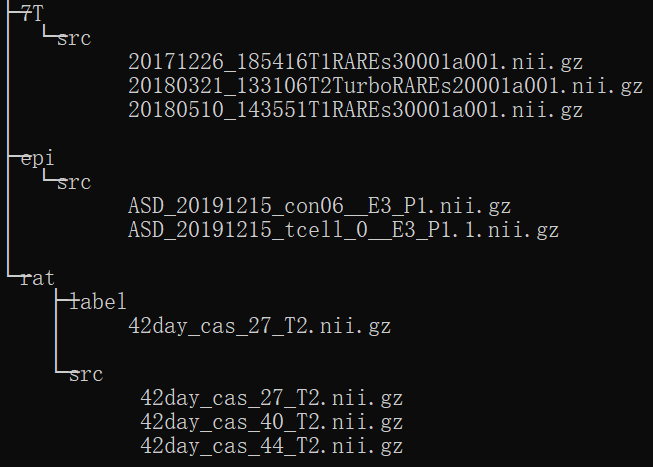

In [5]:
import os
import logging
import warnings
import tensorflow as tf

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # tf log errors only
logging.getLogger('tensorflow').setLevel(logging.ERROR)
print(tf.__version__)

1.15.4


<a name='2.0'></a>
# 2. Cross modality (T2WI -> EPI)

<a name='2.1'></a>
## 2.1 Declare key function and path
In this case, no label required.

In [6]:
from utils.update_model import update_weight

# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# tf.Session(config=config)

input_folder = r'cross_domain/epi/src'
label_folder = ''  # No label required.
output_folder_base = r'cross_domain/epi'  # save pred nii files.(time id based on weight)
old_model_name = r'weight/unet_fp32_all_BN_NoCenterScale_polyic_epoch15_bottle256_04012051/'  # load and adjust BN base on this old model(fixed/source domain usually)
new_model_name = 'EPI-DA'  # The prefix of new weight filename will use this string
cvs_result_base = r'cross_domain/epi'  # evaluation metric in csv. (path of csv, time id)
need_rotate = True

<a name='2.2'></a>
## 2.2 Run BEN's domain transfer/adaptation

In [7]:
# transfer BEN to new domain/dataset
new_weight = update_weight(input_folder, label_folder, need_mkdir=True, weight=old_model_name,
                need_rotate=need_rotate, model_name=new_model_name,
                BN_list=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], freeze=True)
print('Finetune done.\n New model path is : ', new_weight)


# setting filename
import re

num_extract = re.findall(r'\d+', new_weight)
output_folder = output_folder_base + '/' + 'pred' + '-' + num_extract[0]  # e.g. 'pred-04061444'
DA_path = output_folder
cvs_result = cvs_result_base + '/' + new_weight.replace('weight/', '').replace('/', '') + '.csv'
new_weight = new_weight + '.hdf5'

from utils.inference import inference_pipeline
import tensorflow.keras.backend as K

K.clear_session()  # release GRAM

# run inference
inference_pipeline(input_folder,
          output_folder, is_mkdir=True,
          weight=new_weight,
          need_rotate=need_rotate,
          BN_list=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],

          )


Finding  2  nii.gz format files.	
Reading:	 ASD_Xinhua_SJL_20191215_con06__E3_P1.nii.gz
(35, 90, 90)
Reading:	 ASD_Xinhua_SJL_20191215_tcell_0__E3_P1.1.nii.gz
(35, 90, 90)
Done.
Create empty label matrix!

**********	Inferring CT/MRI scans:	**********

Trainable lay:  batch_normalization
Trainable lay:  batch_normalization_1
Trainable lay:  batch_normalization_2
Trainable lay:  batch_normalization_3
Trainable lay:  batch_normalization_4
Trainable lay:  batch_normalization_5
Trainable lay:  batch_normalization_6
Trainable lay:  batch_normalization_7
Trainable lay:  batch_normalization_8
Trainable lay:  batch_normalization_9
Only finetune BN on target domain!


Using TensorFlow backend.


Train on 63 samples, validate on 7 samples
Epoch 1/30
63/63 [==============================] - 8s 125ms/sample - loss: 3.9280 - dice_coef: 5.8535e-09 - val_loss: 0.2037 - val_dice_coef: 5.8334e-07
Epoch 2/30
63/63 [==============================] - 0s 4ms/sample - loss: 3.9304 - dice_coef: 5.8434e-09 - val_loss: 0.2103 - val_dice_coef: 2.9243e-07
Epoch 3/30
63/63 [==============================] - 0s 4ms/sample - loss: 3.9269 - dice_coef: 5.8409e-09 - val_loss: 0.3412 - val_dice_coef: 1.5403e-07
Epoch 4/30
63/63 [==============================] - 0s 4ms/sample - loss: 3.9328 - dice_coef: 5.8362e-09 - val_loss: 0.5299 - val_dice_coef: 1.0724e-07
Epoch 5/30
63/63 [==============================] - 0s 3ms/sample - loss: 3.9201 - dice_coef: 5.8169e-09 - val_loss: 0.6718 - val_dice_coef: 9.2216e-08
Epoch 6/30
63/63 [==============================] - 0s 4ms/sample - loss: 3.9290 - dice_coef: 5.8479e-09 - val_loss: 0.7151 - val_dice_coef: 8.6451e-08
Epoch 7/30
63/63 [=========================

Note: here target domain labels are unseen, we use empty matrix as placeholder, so the '*loss*'， '*dice_coef*', and '*val_loss*' don't seem to work.

<a name='2.3'></a>
## 2.3 Run baseline method

In [8]:
''' zero-shot '''
zeroshot_out_folder = output_folder_base + '/' + 'pred' + '-' + 'zeroshot'
inference_pipeline(input_folder,
          zeroshot_out_folder, is_mkdir=True,
          weight=old_model_name,  # zeroshot
          # weight=new_weight,
          need_rotate=need_rotate,
          BN_list=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],

          )

Makedir:	 cross_domain/epi/pred-zeroshot
Object will save in (Existing) folder/print(save_filename):	 cross_domain/epi/pred-zeroshot
Finding  2  nii.gz format files.	
Reading:	 ASD_Xinhua_SJL_20191215_con06__E3_P1.nii.gz
(35, 90, 90)
Reading:	 ASD_Xinhua_SJL_20191215_tcell_0__E3_P1.1.nii.gz
(35, 90, 90)
Done.

**********	Inferring CT/MRI scans:	**********


**********	 2 file(s) to save: 	**********

Saving:	 (35, 90, 90)
Saving:	 (35, 90, 90)

**********	 Done. 	**********



<a name='2.4'></a>
## 2.4 Visualize the output

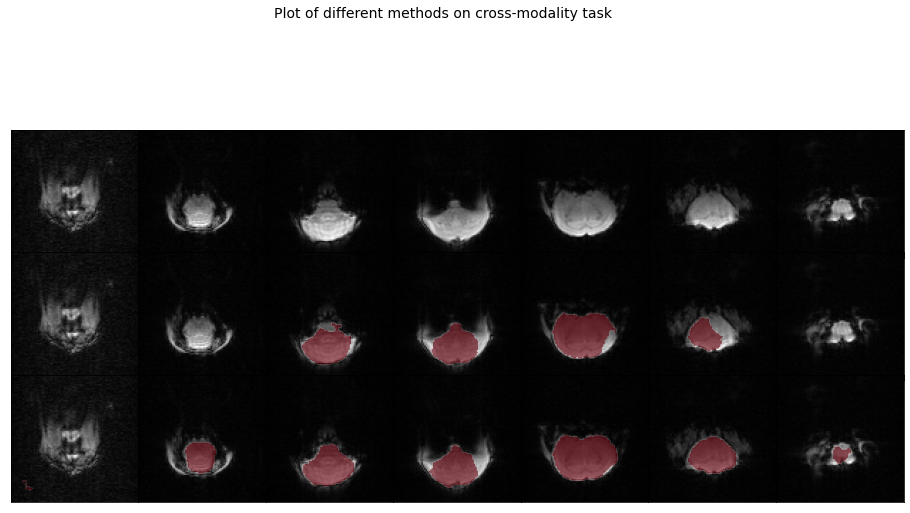

In [9]:
from glob import glob
from utils.load_data import get_itk_array
from utils.visualization import load_slice, plot_segmentation

raw, zeroshot, DA = load_slice(raw_path=r'cross_domain/epi/src',
                  zeroshot_path=r'cross_domain/epi/pred-zeroshot',
                  DA_path=DA_path,
                  scans_num=1)
plot_segmentation(raw, zeroshot, DA, task='modality', hspace=-0.5, figsize=(16,9))

From top raw to the fifth raw: **<font color='#A5A5A5'> *Raw image* </font>**, **<font color='#FF0000'> baseline result </font>** (0 label used), and **<font color='#FF0000'> BEN's </font>** result (0 label used).

For this exemplar domain adaptation (DA) task, No label is used (zero-shot).



<a name='3.0'></a>
# 3.0 Conclusion

BEN shows the capacity to generalize well to other domains with minimal or even without additional labeled data, while the baseline approaches lead to abundant errors.

<a name='4.0'></a>
# 4.0 (Optional) Download new weight

After updating weight [1], BEN has already deployed on this new domain. You can download this weight to use next time without the abovementioned steps.

[1] In practice, we recommend using 4~6 target domain labels for domain adaptation. We also provide a semi-supervised or human-in-the-loop manner to deploy BEN.

In [10]:
# import os
# from google.colab import files

# new_weight_folder = os.path.dirname(new_weight)
# print(new_weight_folder)
# os.system(f"zip -r -j download.zip {new_weight_folder}/*")
# files.download("/content/BEN/weight/weight.zip")